## Veri Setinin Yüklenmesi ve Ön İşlenmesi

In [51]:
# Gerekli kütüphanelerin import edilmesi
import numpy as np                        # Sayısal işlemler ve dizi manipülasyonları için kullanılır
import matplotlib.pyplot as plt          # Grafik ve görselleştirme için kullanılır

import tensorflow as tf                  # Derin öğrenme modelleri oluşturmak için temel kütüphane

# TensorFlow içinden Keras modülleri import ediliyoruz
from tensorflow.keras.datasets import imdb                         # IMDB veri seti (film yorumları) import ediliyoruz
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Dizi uzunluklarını eşitlemek için kullanacağız
from tensorflow.keras.models import Sequential                     # Katmanlı model yapısı için
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout  # Modelde kullanılacak katmanlar
from tensorflow.keras.callbacks import EarlyStopping               # Aşırı öğrenmeyi (overfitting) önlemek için erken durdurma

# Sklearn'den metrik hesaplama ve ROC eğrisi için fonksiyonlar
from sklearn.metrics import classification_report, roc_curve, auc  # Performans değerlendirme için

# Keras Tuner: Hiperparametre ayarlaması için kullanılan araç
import kerastuner as kt
from kerastuner.tuners import RandomSearch  # Rastgele arama ile en iyi parametrelerin bulunması

# Uyarıları gizlemek için
import warnings
warnings.filterwarnings("ignore")  # Çalışma esnasında ekranda çıkacak uyarıları gizler


In [53]:
# IMDB veri setini yüklüyoruz. Toplam 50.000 film yorumu içerir.
# 'num_words=10000' parametresi, yalnızca en sık geçen 10.000 kelimeyi kullanacağımız anlamına gelir.
# 0 -> olumsuz yorum, 1 -> olumlu yorum
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Veri ön işleme:
# RNN modelleri sabit uzunluktaki girişlere ihtiyaç duyar.
# Bu yüzden tüm yorumları aynı uzunluğa getirmek için padding (doldurma) uyguluyoruz.

maxlen = 100  # Tüm yorumları 100 kelime uzunluğuna getiriyoruz (fazlaysa kes, azsa başına 0 ekle)

# Eğitim verisini pad ediyoruz
x_train = pad_sequences(x_train, maxlen=maxlen)

# Test verisini de aynı şekilde pad ediyoruz
x_test = pad_sequences(x_test, maxlen=maxlen)

# Eğitim verisinin boyutunu kontrol ediyoruz
x_train.shape

(25000, 100)

## Modelin Oluşturulması (Hiperparametrelerle RNN Mimarisi)

In [54]:
# Hiperparametre ayarlanabilir bir model fonksiyonu tanımlıyoruz
# Bu fonksiyon Keras Tuner tarafından çağrılacak ve farklı kombinasyonlarda model eğitilecek
def build_model(hp):  # hp: hyperparameter nesnesi, Keras Tuner tarafından sağlanır

    model = Sequential()  # Katmanları sırayla ekleyeceğimiz temel model

    # Embedding katmanı: kelimeleri (kelime ID'lerini) yoğun vektör temsillerine dönüştürür
    model.add(Embedding(
        input_dim=10000,  # Kelime sözlüğü boyutu (sadece en sık geçen 10.000 kelime)
        output_dim=hp.Int("embedding_output", min_value=32, max_value=128, step=32),  # Embedding vektör boyutu (32, 64, 96, 128)
        input_length=maxlen  # Giriş dizisinin uzunluğu (önceden 100 olarak belirlenmişti)
    ))

    # SimpleRNN katmanı: zaman serisi verisini işler (örneğin kelime sırası)
    model.add(SimpleRNN(
        units=hp.Int("rnn_units", min_value=32, max_value=256, step=32)  # RNN hücre sayısı (32, 64, ..., 256)
    ))

    # Dropout katmanı: Aşırı öğrenmeyi (overfitting) önlemek için bazı nöronları rastgele devre dışı bırakır
    model.add(Dropout(
        rate=hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)  # 0.2, 0.3, 0.4, 0.5
    ))

    # Çıkış katmanı: İkili sınıflandırma için sigmoid aktivasyonlu tek nöron
    model.add(Dense(1, activation="sigmoid"))  # Çıktı değeri 0 ile 1 arasında olur

    # Modeli derliyoruz (compile)
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop"]),  # Optimizasyon algoritması seçimi
        loss="binary_crossentropy",  # İkili sınıflandırma için uygun kayıp fonksiyonu
        metrics=["accuracy", "AUC"]  # Doğruluk ve ROC eğrisi altında kalan alan (AUC) metriği
    )

    return model  # Modeli geri döndürüyoruz


## Hiperparametre Araması ve Model Eğitimi

In [55]:
# Hiperparametre araması için Keras Tuner'dan RandomSearch kullanıyoruz.
# Amaç: Farklı model konfigürasyonlarıyla denemeler yaparak en iyi sonucu bulmak.

tuner = RandomSearch(
    build_model,               # Optimize edilecek model fonksiyonumuz
    objective="val_loss",      # Hedef metrik: doğrulama kaybı (en düşük val_loss en iyisidir)
    max_trials=4,              # Toplamda 4 farklı hiperparametre kombinasyonu denenecek
    executions_per_trial=1,    # Her kombinasyon için 1 kez eğitim yapılacak
    directory="/RNN/rnn_tuner_directory",  # Deneme sonuçlarının kaydedileceği dizin
    project_name="imdb_rnn"    # Proje adı (alt klasör oluşturulur)
)

# Erken durdurma mekanizması:
# Doğrulama kaybı 5 epoch boyunca iyileşmezse eğitim durdurulur.
early_stopping = EarlyStopping(
    monitor="val_loss",         # İzlenecek metrik: val_loss
    patience=5,                 # Kaç epoch boyunca iyileşme beklenmeli
    restore_best_weights=True  # En iyi ağırlıklar otomatik olarak geri yüklenir
)

# Modelin eğitilmesi ve hiperparametre araması başlatılır.
tuner.search(
    x_train, y_train,           # Eğitim verisi
    epochs=10,                  # Her deneme için maksimum 10 epoch
    validation_split=0.2,       # %20'lik kısmı doğrulama için ayrılır
    callbacks=[early_stopping]  # Erken durdurma callback'i kullanılır
)


Trial 4 Complete [00h 02m 20s]
val_loss: 0.4108872413635254

Best val_loss So Far: 0.4108872413635254
Total elapsed time: 00h 41m 05s


## En İyi Modelin Seçilmesi ve Test Verisi Üzerinde Değerlendirme

In [56]:
# Tuner tarafından denenen modeller arasından en iyi performansı gösteren modeli alıyoruz.
best_model = tuner.get_best_models(num_models=1)[0]

# Seçilen en iyi modeli test verisi üzerinde değerlendiriyoruz.
loss, accuracy, auc_score = best_model.evaluate(x_test, y_test)

# Sonuçları yazdırıyoruz
print(f"Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}, Test AUC: {auc_score:.3f}")

# Model ile test verisi üzerinde tahmin yapıyoruz.
y_pred_prob = best_model.predict(x_test)

# Tahmin edilen olasılıkları ikili sınıflara çeviriyoruz:
# 0.5'ten büyükse 1 (olumlu), değilse 0 (olumsuz)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Modelin sınıflandırma başarımını detaylı olarak raporluyoruz
print(classification_report(y_test, y_pred))

# ROC eğrisi için gerekli olan false positive rate (fpr) ve true positive rate (tpr) değerlerini hesaplıyoruz
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# ROC eğrisinin altındaki alan (AUC) ne kadar büyükse, model o kadar iyi ayrım yapıyordur
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - AUC: 0.9007 - accuracy: 0.8274 - loss: 0.4081 
Test Loss: 0.406, Test Accuracy: 0.829, Test AUC: 0.902
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     12500
           1       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

ROC AUC: 0.902


## ROC Eğrisinin Görselleştirilmesi

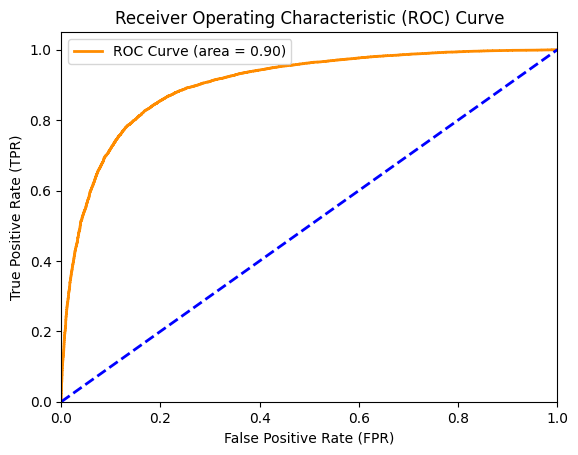

In [57]:
# Yeni bir figür (grafik) oluşturuyoruz
plt.figure()

# ROC eğrisini çiziyoruz
plt.plot(fpr, tpr, color="darkorange", lw=2, 
         label="ROC Curve (area = %0.2f)" % roc_auc)

# Model rastgele tahmin yapsaydı oluşacak eğri (diyagonal çizgi)
plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--")

# X ve Y eksen sınırlarını belirliyoruz
plt.xlim([0, 1])
plt.ylim([0, 1.05])

# Eksen etiketleri
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")

# Grafik başlığı
plt.title("Receiver Operating Characteristic (ROC) Curve")

# Etiketleri gösteriyoruz (ROC alanı dahil)
plt.legend()

# Grafiği ekrana çizdiriyoruz
plt.show()